In [2]:
runCNN = True

In [3]:
import os
import scipy.signal
os.getcwd()

'/global/u1/a/ajivani/WLROM/WhiteLight'

In [4]:
current_dir = os.getcwd()

In [5]:
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import copy

In [6]:
%matplotlib inline

In [7]:
import time

In [8]:
from sunpy.visualization import colormaps as cm

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
import argparse

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--debug', action='store_true')
parser.add_argument('-runCNN', type=eval, default=True, choices=[True, False])


args = parser.parse_args(args=())

In [12]:
args

Namespace(adjoint=True, debug=False, lr=0.1, runCNN=True, tol=0.001)

In [13]:
args.tol

0.001

In [14]:
# adjoint=True

In [15]:
!pip install -q --user torchdiffeq

In [16]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
device

device(type='cuda', index=0)

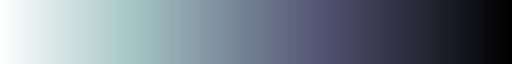

In [19]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

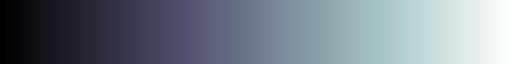

In [20]:
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

In [21]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [22]:
import sys
# sys.path.insert(1, '/home/ajivani/WLROM/EdgeSS')
sys.path.insert(1, os.path.join(current_dir, "..", "EdgeSS"))

In [23]:
import edge_utils as edut

In [24]:
import cnn_utils as ut

### RESIZE DATA APPROPRIATELY

In [25]:
X_orig = np.load("./CR2161_tDecay2h_Polar_Compressed.npy")

In [26]:
X_orig.shape

(64, 256, 90, 278)

In [27]:
X = X_orig.reshape((64 * 256, 90, 278))[:, :, :]

In [28]:
X.shape

(16384, 90, 278)

In [29]:
sid=0

In [30]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [31]:
tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx=sid)

In [32]:
tMinIdx

11

In [33]:
tMaxIdx

79

In [34]:
all_times = np.linspace(2, 180, 90)

In [35]:
valid_times = np.arange(tMin, tMax + 2, step=2)
valid_times

array([ 24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114., 116., 118., 120., 122., 124., 126., 128., 130., 132.,
       134., 136., 138., 140., 142., 144., 146., 148., 150., 152., 154.,
       156., 158., 160.])

In [36]:
validTimeStartIdx = np.argwhere(all_times == valid_times[0])[0][0]
validTimeStartIdx

11

In [37]:
tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
tTrainEnd

114.0

In [38]:
trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
trainEndIdx

45

In [39]:
trainEndIdxAllTimes = np.argwhere(all_times == tTrainEnd)[0][0]
trainEndIdxAllTimes

56

In [40]:
all_times[(trainEndIdxAllTimes + 1):]

array([116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158.,
       160., 162., 164., 166., 168., 170., 172., 174., 176., 178., 180.])

In [41]:
tTrain = valid_times[:(trainEndIdx + 1)]

In [42]:
tTrain

array([ 24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114.])

In [43]:
tTest = valid_times[(trainEndIdx + 1):]
tTest

array([116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158.,
       160.])

In [44]:
tTrainScaled = (tTrain - tMin) / (tMax - tMin)
tTestScaled = (tTest - tMin) / (tMax - tMin)

tAllScaled = (valid_times - tMin) / (tMax - tMin)

In [45]:
tAllScaled.shape

(69,)

In [46]:
nTrain = len(tTrain)
nTrain

46

In [47]:
x_orig_torch_full = X_orig[:, :, tMinIdx:(tMaxIdx + 1), sid]
x_orig_torch_full = x_orig_torch_full.transpose((2, 0, 1))
x_orig_torch_full = torch.from_numpy(np.expand_dims(np.float32(x_orig_torch_full), axis=1)).to(device)

x_orig_torch_full.shape

torch.Size([69, 1, 64, 256])

In [48]:
import torchvision
import torchvision.transforms as T

resize=True
rs_dims = (32, 128)

In [49]:
# Slice data for a particular sID!
x_train_orig = X_orig[:, :, validTimeStartIdx:(trainEndIdxAllTimes + 1), sid]
x_train_orig = x_train_orig.transpose((2, 0, 1))
x_train_orig_torch = torch.from_numpy(np.expand_dims(np.float32(x_train_orig), axis=1)).to(device)

x_orig_torch_full = X_orig[:, :, tMinIdx:(tMaxIdx + 1), sid]
x_orig_torch_full = x_orig_torch_full.transpose((2, 0, 1))
x_orig_torch_full = torch.from_numpy(np.expand_dims(np.float32(x_orig_torch_full), axis=1)).to(device)

x_train_flat = X[:, validTimeStartIdx:(trainEndIdxAllTimes + 1), sid]
x_train_flat = x_train_flat.transpose((1, 0))
x_train_flat_torch = torch.from_numpy(np.expand_dims(np.float32(x_train_flat), axis=1)).to(device)

if resize:
    x_train_orig_torch = T.Resize(size=rs_dims, antialias=True)(x_train_orig_torch)
    x_orig_torch_full = T.Resize(size=rs_dims, antialias=True)(x_orig_torch_full)
    x_train_flat_torch = x_train_orig_torch.flatten(start_dim=2, end_dim=3)

x_orig_torch_full.shape, x_train_orig_torch.shape, x_train_flat_torch.shape

(torch.Size([69, 1, 32, 128]),
 torch.Size([46, 1, 32, 128]),
 torch.Size([46, 1, 4096]))

In [50]:
x0_train_orig = x_train_orig[tMinIdx, :, :]
x0_train_orig_torch = torch.from_numpy(np.expand_dims(np.float32(x0_train_orig), axis=(0, 1))).to(device)

if resize:
    x0_train_orig_torch = T.Resize(size=rs_dims, antialias=True)(x0_train_orig_torch)


# x0_train_flat = x0_train_orig.flatten()
# x0_train_flat_torch = torch.from_numpy(np.float32(x0_train_flat)).reshape((1, len(x0_train_flat))).to(device)

x0_train_flat_torch = torch.flatten(x0_train_orig_torch, start_dim=1)

x0_train_orig_torch.shape, x0_train_flat_torch.shape

(torch.Size([1, 1, 32, 128]), torch.Size([1, 4096]))

In [51]:
torch.flatten(x_train_orig_torch, start_dim=2, end_dim=3).shape

torch.Size([46, 1, 4096])

In [52]:
t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
t_torch_full = torch.tensor(np.float32(tAllScaled)).to(device)

t_torch_full.shape, t_train_torch.shape

(torch.Size([69]), torch.Size([46]))

In [53]:
data_size = t_train_torch.shape[0]
batch_time = 5
batch_size = 10

#### Define Conv architecture, with flattening layer

count parameters, ensure within reasonable range. Only 2-3 convolutions if possible.

In [54]:
# from https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py
# 128, 1, 28, 28
# 128, 64, 26, 26
# 128, 64, 13, 13
# 128, 64, 6, 6
# CONCATCONV?
# 128, 65, 13, 13
# 128, 64, 13, 13
# 128, 64, 13, 13
# ADAPTIVE_AVG_POOL_2D
# 128, 64, 1, 1
# 128, 64 (after Flatten function in file)
# 128, 10 (after nn.Linear(64, 10)


### Lessons? More output channels, fewer dimensions, gradually reduce them to 1, 1. Then fewer dimensions to deal with

In [55]:
# start from?
# 10, 1, 64, 256 - by0
# 5, 10, 1, 64, 256 - by! (or corresponding flattened versions! 5, 10, 1, 64 * 256)
# for each by0,
# 10, 32, 63, 254??
# 10, 32, 32, 128
# 10, 32, 16, 64
# 10, 32, 32, 128
# 10, 32, 32, 128
# AVG POOL
# 10, 32, 1, 1
# 10, 32
# 10, 64 * 256??


In [56]:
ut.getHC(8, 32,
         kernel_size=(3, 3),
         stride=(1, 1),
         padding=(1, 1),
         dilation=(1, 1))

(8.0, 32.0)

In [57]:
# 32, 128
# 32, 128
# 16, 64
# 8, 32
# 1, 1, i.e.
# 10, 32, 1, 1
# 10, 32 * 128

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def group_norm(dim):
    return nn.GroupNorm(min(16, dim), dim)


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class ODEfunc(nn.Module):
    def __init__(self):
        super(ODEfunc, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                  kernel_size=(3, 3), 
                  stride=(1, 1),
                  padding=(1, 1),
                  dilation=(1, 1))

        self.norm1 = group_norm(32)
        
        self.tanh = nn.Tanh()
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, 
                          kernel_size=(4, 4), 
                          stride=(2, 2),
                          padding=(1, 1),
                          dilation=(1, 1))
        
        self.norm2 = group_norm(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, 
                          kernel_size=(4, 4), 
                          stride=(2, 2),
                          padding=(1, 1),
                          dilation=(1, 1))

        self.pool1 = nn.AdaptiveAvgPool2d((1, 1))

        self.flat1 = Flatten()

        self.lin1 = nn.Linear(32, 32 * 128)

    def forward(self, t, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.tanh(out)
        out = self.conv2(out)
        out = self.norm1(out)
        out = self.tanh(out)
        out = self.conv3(out)
        out = self.norm1(out)
        out = self.tanh(out)
        out = self.pool1(out)
        out = self.flat1(out)
        out = self.lin1(out)
        out = out.view(-1, 1, 32, 128)
        
        return out

In [59]:
# model_1 = ODEfunc().to(device)

In [60]:
# optensor = model_1(torch.tensor([0.5]).to(device), torch.rand(10, 1, 32, 128).float().to(device))
# optensor.shape

In [61]:
# count_parameters(model_1) # Answer: 168448, nearly 4 times more than before - but better than when we were using full images!!!

In [62]:
# odeint(model_1, torch.rand(10, 1, 32, 128).float().to(device), torch.tensor([0, 0.2, 0.4, 0.6, 0.8, 1]).float().to(device)).shape

In [63]:
def get_batch(torch_train_data, torch_train_time, batch_time=5, batch_size=10):
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    batch_y0 = torch_train_data[s]
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]
        
    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [64]:
my_cnn_model = ODEfunc().to(device)
optimizer = optim.Adam(my_cnn_model.parameters(), lr=1e-3)
end = time.time()

In [65]:
n_iters = 1000
test_freq = 5

In [66]:
# by0, bt, by = get_batch(x_train_orig_torch, t_train_torch)

In [67]:
# by.shape

In [68]:
# torch.squeeze(odeint(my_cnn_model, by0[[0], :, :, :], bt[0, :]).to(device), 1).shape

In [69]:
x_orig_torch_full[[0]].shape

torch.Size([1, 1, 32, 128])

In [70]:
odeint(my_cnn_model, x_orig_torch_full[[0]], t_torch_full).shape

torch.Size([69, 1, 1, 32, 128])

In [71]:
x_orig_torch_full.shape

torch.Size([69, 1, 32, 128])

In [72]:
if runCNN:
    for itr in range(1, n_iters + 1):
        optimizer.zero_grad()

        batch_y0, batch_t, batch_y = get_batch(x_train_orig_torch, t_train_torch)

        pred_y = torch.zeros_like(batch_y)
        
        for i in range(batch_size):
            pred_y[:, i, :, :, :] = torch.squeeze(odeint(my_cnn_model, batch_y0[[i], :, :, :], batch_t[i, :]).to(device), 1)
        
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()


        # time_meter.update(time.time() - end)
        # loss_meter.update(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                pred_y_full_series = torch.squeeze(odeint(my_cnn_model, x_orig_torch_full[[0]], t_torch_full), 1)
                loss_full_series = torch.mean(torch.abs(pred_y_full_series 
                                                        - x_orig_torch_full))
                print("Iter {:04d} | Total Loss {:.6f} ".format(itr,
                                                                loss_full_series.item(), 
                                                                ))
                # ii += 1

        end = time.time()

Iter 0005 | Total Loss 0.119624 
Iter 0010 | Total Loss 0.100640 
Iter 0015 | Total Loss 0.087986 
Iter 0020 | Total Loss 0.075631 
Iter 0025 | Total Loss 0.071758 
Iter 0030 | Total Loss 0.071428 
Iter 0035 | Total Loss 0.067452 
Iter 0040 | Total Loss 0.066001 
Iter 0045 | Total Loss 0.063808 
Iter 0050 | Total Loss 0.061105 
Iter 0055 | Total Loss 0.058641 
Iter 0060 | Total Loss 0.056272 
Iter 0065 | Total Loss 0.053998 
Iter 0070 | Total Loss 0.052262 
Iter 0075 | Total Loss 0.050305 
Iter 0080 | Total Loss 0.048294 
Iter 0085 | Total Loss 0.046811 
Iter 0090 | Total Loss 0.045875 
Iter 0095 | Total Loss 0.045330 
Iter 0100 | Total Loss 0.044768 
Iter 0105 | Total Loss 0.043839 
Iter 0110 | Total Loss 0.042641 
Iter 0115 | Total Loss 0.043332 
Iter 0120 | Total Loss 0.042943 
Iter 0125 | Total Loss 0.042445 
Iter 0130 | Total Loss 0.042153 
Iter 0135 | Total Loss 0.042790 
Iter 0140 | Total Loss 0.042143 
Iter 0145 | Total Loss 0.042215 
Iter 0150 | Total Loss 0.041589 
Iter 0155 

In [78]:
with torch.no_grad():
    pred_y_final = torch.squeeze(odeint(my_cnn_model, x_orig_torch_full[[0]], t_torch_full), 1).cpu().numpy()[:, 0, :, :]

In [79]:
pred_y_final.shape

(69, 32, 128)

In [80]:
x_orig_full_cpu = x_orig_torch_full.cpu().numpy()[:, 0, :, :]

In [81]:
x_orig_full_cpu.shape

(69, 32, 128)

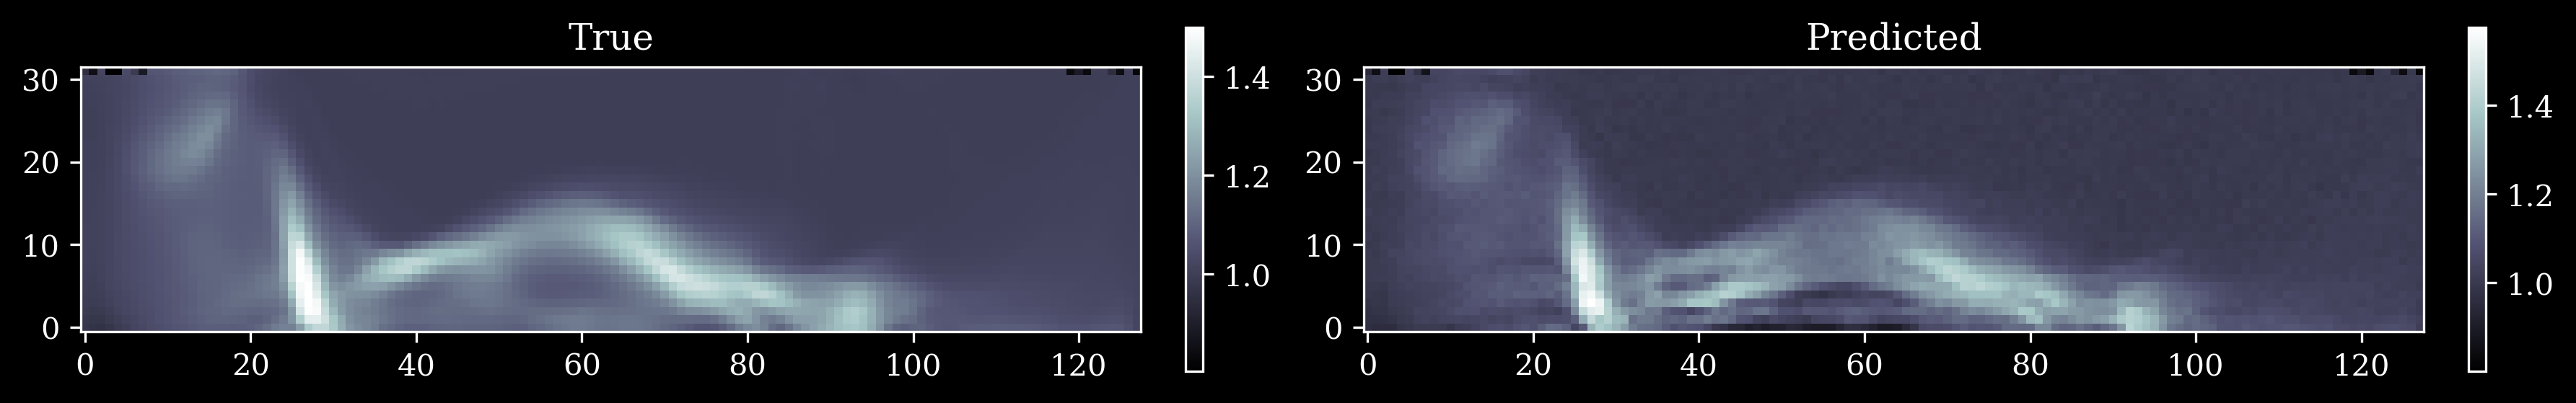

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
axs = ax.ravel()
im0 = axs[0].imshow(x_orig_full_cpu[40, :, :],
            origin="lower",
            cmap=lc3_reg)
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04, ax=axs[0])

im1 = axs[1].imshow(pred_y_final[40, :, :],
                   origin="lower",
                   cmap=lc3_reg)
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04, ax=axs[1])
fig.tight_layout()

Ok so this is not completely a failure, its still really really bad, but the results are better than before!! almost the same outcome whether we do 1000 iterations or 4000.